Example of using `interarray` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [1]:
%config InlineBackend.figure_formats = ['svg']
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from interarray.importer import load_repository
from interarray.plotting import gplot
from interarray.svg import svgplot
from interarray.interarraylib import calcload, G_from_S
from interarray.mesh import make_planar_embedding
from interarray.pathfinding import PathFinder
from interarray.heuristics import CPEW

In [3]:
import pyomo.environ as pyo
import interarray.MILP.pyomo as omo
import interarray.MILP.ortools as ort

## Solvers

Just one is required. Using `gurober` in this example.

In [4]:
gurober = pyo.SolverFactory('gurobi', solver_io='python')
gurober.available(), type(gurober)

(True, pyomo.solvers.plugins.solvers.gurobi_direct.GurobiDirect)

In [5]:
cplexer = pyo.SolverFactory('cplex', solver_io='python')
cplexer.available(), type(cplexer)

(True, pyomo.solvers.plugins.solvers.cplex_direct.CPLEXDirect)

In [6]:
orter = ort.cp_model.CpSolver()

## Load input data

In [7]:
locations = load_repository()

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [8]:
L = locations.taylor

Note: To view SVG cell outputs, trust this notebook first.

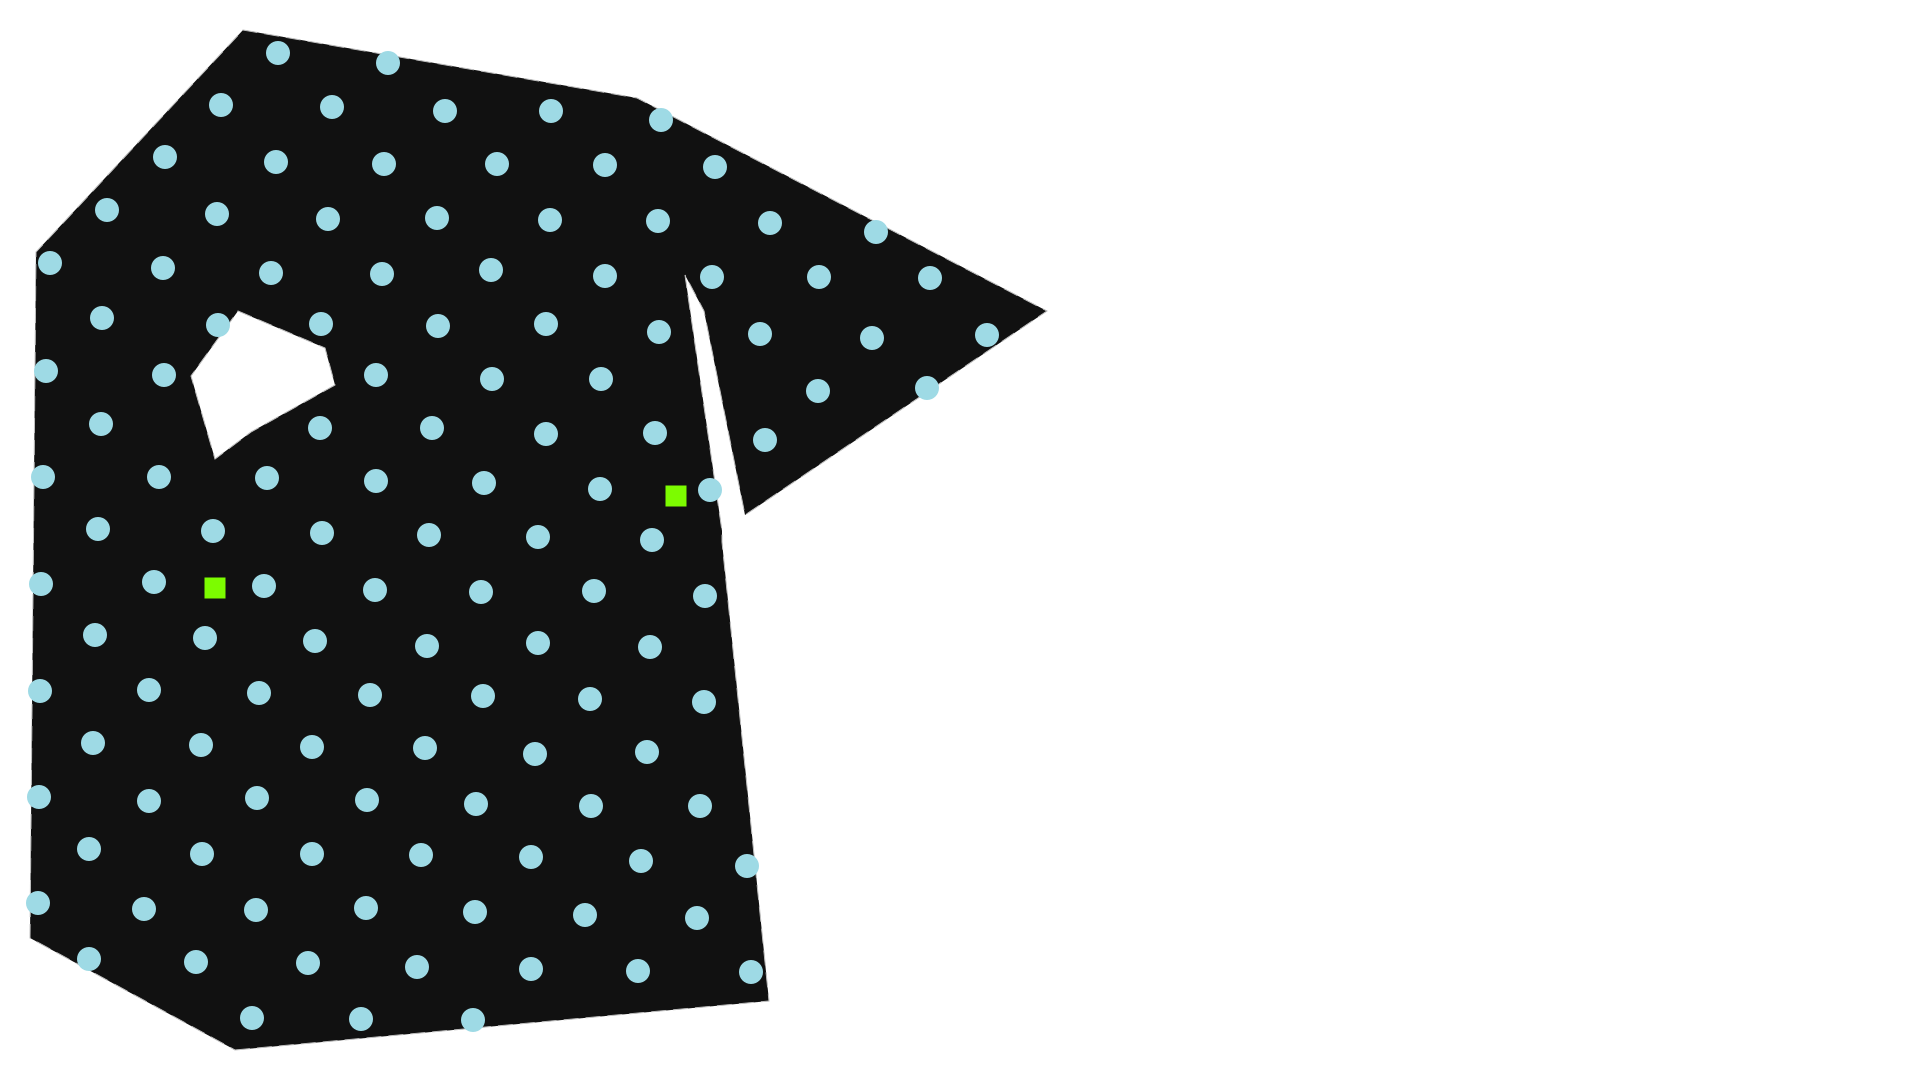

In [9]:
svgplot(L, landscape=False)

When the location has more than one substation, we cannot use the *HGS-CVRP* meta-heuristic. Instead, we may use a very fast heuristic: *Crossing-Preventing Esau-Williams* (CPEW).

CPEW has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

## Generate the warm-start solution

In [10]:
P, A = make_planar_embedding(L)

In [11]:
S_cpew = CPEW(L, capacity=5)
calcload(S_cpew)

## Visualizing the warm-start solution

This section is unecessary in production.

In [12]:
G_cpew = G_from_S(S_cpew, A)

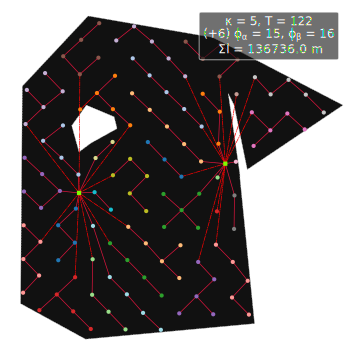

In [13]:
gplot(G_cpew, node_tag=None, landscape=False);

## Create MILP model and solve it

In [14]:
model = omo.make_min_length_model(
    A, S_cpew.graph['capacity'],
    gateXings_constraint=False,
    gates_limit=False,
    branching=True
)
omo.warmup_model(model, S_cpew);

In [15]:
gurober.options.mipgap = 0.005  # 0.5 %
gurober.options.timelimit = 10  # [s]
gurober.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = gurober.solve(model, warmstart=model.warmed_by, tee=True)

Solving "taylor": {R=2, T=122, k=5}



Set parameter OutputFlag to value 1


Set parameter MIPGap to value 0.005


Set parameter TimeLimit to value 10


Set parameter MIPFocus to value 1


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))


CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


Non-default parameters:


TimeLimit  10


MIPGap  0.005


MIPFocus  1


Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk


Optimize a model with 4417 rows, 2880 columns and 16454 nonzeros


Model fingerprint: 0x8f3bdc8b


Variable types: 0 continuous, 2880 integer (1440 binary)


Coefficient statistics:


  Matrix range     [1e+00, 5e+00]


  Objective range  [4e+02, 1e+04]


  Bounds range     [1e+00, 5e+00]


  RHS range        [1e+00, 1e+02]


Loaded user MIP start with objective 136736


Presolve removed 645 rows and 0 columns


Presolve time: 0.02s


Presolved: 3772 rows, 2880 columns, 13726 nonzeros


Variable types: 0 continuous, 2880 integer (1440 binary)


Root relaxation: objective 1.199416e+05, 3123 iterations, 0.03 seconds (0.06 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 119941.581    0  211 136736.421 119941.581  12.3%     -    0s


H    0     0                    134676.90352 119941.581  10.9%     -    0s


H    0     0                    134673.93542 119941.581  10.9%     -    0s


H    0     0                    134605.81407 119941.581  10.9%     -    0s


H    0     0                    134534.51007 119941.581  10.8%     -    0s


H    0     0                    134173.76060 119941.581  10.6%     -    0s


H    0     0                    133563.67259 119941.581  10.2%     -    0s


H    0     0                    132701.02215 121414.824  8.50%     -    0s


H    0     0                    132655.51839 121414.824  8.47%     -    0s


H    0     0                    132541.27477 121414.824  8.39%     -    0s


H    0     0                    132035.95651 121414.824  8.04%     -    0s


     0     0 121414.824    0  413 132035.957 121414.824  8.04%     -    0s


H    0     0                    130754.02504 121414.824  7.14%     -    0s


H    0     0                    130750.11977 121414.824  7.14%     -    0s


H    0     0                    129850.21573 121414.824  6.50%     -    0s


H    0     0                    129781.10122 121414.824  6.45%     -    0s


     0     0 121738.879    0  396 129781.101 121738.879  6.20%     -    0s


     0     0 121747.638    0  410 129781.101 121747.638  6.19%     -    0s


     0     0 121749.217    0  408 129781.101 121749.217  6.19%     -    0s


     0     0 121749.392    0  408 129781.101 121749.392  6.19%     -    0s


H    0     0                    129716.14888 122246.118  5.76%     -    0s


H    0     0                    129105.60997 122246.118  5.31%     -    0s


     0     0 122267.871    0  416 129105.610 122267.871  5.30%     -    0s


H    0     0                    128794.28991 122337.438  5.01%     -    0s


     0     0 122337.438    0  436 128794.290 122337.438  5.01%     -    0s


H    0     0                    128793.04523 122338.574  5.01%     -    0s


     0     0 122338.574    0  441 128793.045 122338.574  5.01%     -    0s


     0     0 122339.044    0  436 128793.045 122339.044  5.01%     -    0s


H    0     0                    128327.73138 122547.173  4.50%     -    0s


H    0     0                    128167.38786 122547.173  4.39%     -    0s


     0     0 122547.173    0  493 128167.388 122547.173  4.39%     -    0s


H    0     0                    128028.61085 122547.173  4.28%     -    0s


H    0     0                    127868.26732 122547.173  4.16%     -    0s


     0     0 122604.584    0  526 127868.267 122604.584  4.12%     -    0s


     0     0 122614.525    0  519 127868.267 122614.525  4.11%     -    0s


     0     0 122616.019    0  527 127868.267 122616.019  4.11%     -    0s


     0     0 122616.721    0  531 127868.267 122616.721  4.11%     -    0s


     0     0 122616.743    0  533 127868.267 122616.743  4.11%     -    0s


     0     0 122794.639    0  525 127868.267 122794.639  3.97%     -    1s


     0     0 122851.580    0  538 127868.267 122851.580  3.92%     -    1s


     0     0 122858.164    0  545 127868.267 122858.164  3.92%     -    1s


     0     0 122862.404    0  549 127868.267 122862.404  3.91%     -    1s


     0     0 122862.909    0  556 127868.267 122862.909  3.91%     -    1s


     0     0 122942.379    0  542 127868.267 122942.379  3.85%     -    1s


H    0     0                    127843.23159 122942.379  3.83%     -    1s


H    0     0                    127690.35093 122942.379  3.72%     -    1s


H    0     0                    127587.42735 122942.379  3.64%     -    3s


H    0     0                    127541.36459 122942.379  3.61%     -    3s


     0     2 122942.379    0  541 127541.365 122942.379  3.61%     -    4s


H   71    83                    127421.54307 123015.252  3.46%  93.9    4s


   105   126 123228.175   13  478 127421.543 123015.252  3.46%  93.4    5s


H  176   186                    127326.29990 123015.252  3.39%  95.6    5s


H  190   194                    127037.61981 123015.252  3.17%  97.9    5s


H  612   573                    127025.71515 123015.252  3.16%  80.9    6s


H  614   587                    126812.62095 123015.252  2.99%  81.0    6s


H  706   630                    126525.66791 123015.252  2.77%  79.0    7s


H  799   694                    126436.24506 123035.885  2.69%  77.3    7s


H  869   734                    126432.37395 123044.458  2.68%  76.4    7s


H  927   734                    125826.22547 123044.458  2.21%  76.5    7s


H 1029   759                    125496.03183 123044.458  1.95%  77.0    9s


  1200   881     cutoff   37      125496.032 123053.354  1.95%  74.3   10s


Cutting planes:


  Gomory: 27


  Lift-and-project: 9


  Cover: 3


  MIR: 282


  StrongCG: 4


  Flow cover: 82


  Flow path: 7


  Zero half: 1


  Network: 16


  Relax-and-lift: 2


Explored 1262 nodes (98496 simplex iterations) in 10.03 seconds (12.83 work units)


Thread count was 16 (of 16 available processors)


Solution count 10: 125496 125826 126432 ... 127422


Time limit reached


Best objective 1.254960318323e+05, best bound 1.230700509573e+05, gap 1.9331%


containing a solution


## Trace routes from solution topology

In [16]:
S_gurobi = omo.S_from_solution(model, gurober, status)
F_gurobi = G_from_S(S_gurobi, A)
G = PathFinder(F_gurobi, planar=P, A=A).create_detours()

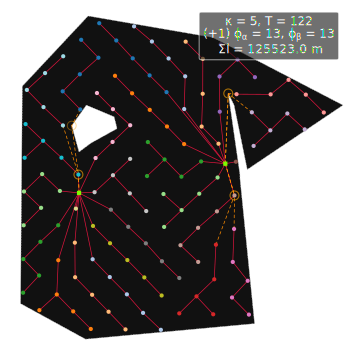

In [17]:
gplot(G, node_tag=None, landscape=False);